<a href="https://colab.research.google.com/github/nadiasuweer4ya/SkinCancer-ISIC-ClassificationUsing-DenseNet201/blob/main/Skin_Cancer_Classification_Using_DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.2 MB/s eta 0:00:00


In [3]:
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic
!unzip skin-cancer9-classesisic

100% 783M/786M [00:41<00:00, 21.1MB/s]
100% 786M/786M [00:41<00:00, 20.0MB/s]
Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Col

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils import to_categorical

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [8]:
import os
import pandas as pd

train_dir = '/content/skincancer/Train'
test_dir = '/content/skincancer/Test'

train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = test_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

<ipython-input-8-e57b32d24528>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-8-e57b32d24528>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-8-e57b32d24528>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-8-e57b32d24528>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_pa

image_path label
0     /content/skincancer/Train/dermatofibroma/ISIC_...     0
1     /content/skincancer/Train/dermatofibroma/ISIC_...     0
2     /content/skincancer/Train/dermatofibroma/ISIC_...     0
3     /content/skincancer/Train/dermatofibroma/ISIC_...     0
4     /content/skincancer/Train/dermatofibroma/ISIC_...     0
...                                                 ...   ...
2352  /content/skincancer/Test/actinic keratosis/ISI...     8
2353  /content/skincancer/Test/actinic keratosis/ISI...     8
2354  /content/skincancer/Test/actinic keratosis/ISI...     8
2355  /content/skincancer/Test/actinic keratosis/ISI...     8
2356  /content/skincancer/Test/actinic keratosis/ISI...     8

[2357 rows x 2 columns]

In [9]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'dermatofibroma',
 1: 'melanoma',
 2: 'nevus',
 3: 'seborrheic keratosis',
 4: 'squamous cell carcinoma',
 5: 'pigmented benign keratosis',
 6: 'basal cell carcinoma',
 7: 'vascular lesion',
 8: 'actinic keratosis'}

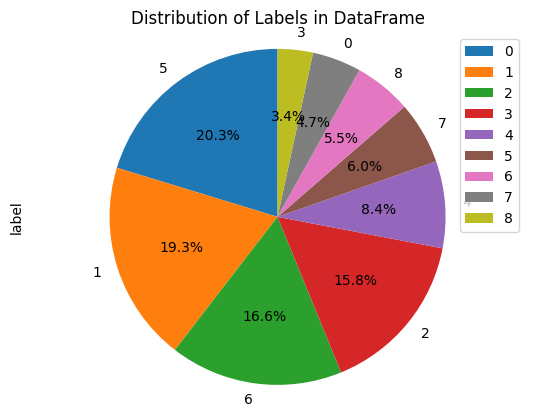

In [10]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [11]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               dermatofibroma                 111       
1               melanoma                       454       
2               nevus                          373       
3               seborrheic keratosis           80        
4               squamous cell carcinoma        197       
5               pigmented benign keratosis     478       
6               basal cell carcinoma           392       
7               vascular lesion                142       
8               actinic keratosis              130       
------------------------------------------------------------
Total                                         2357      


In [12]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

<ipython-input-12-bc8b811b80a6>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [13]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
import multiprocessing

max_workers = multiprocessing.cpu_count()
max_workers

12

In [15]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

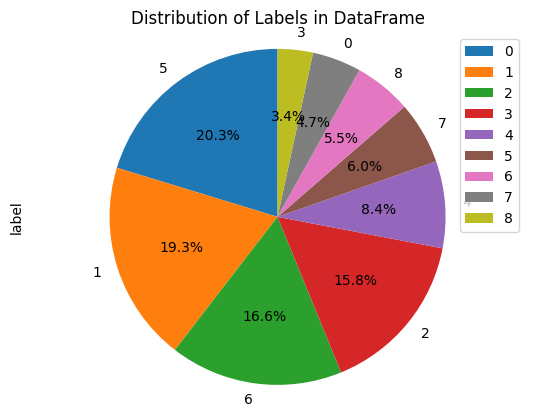

In [16]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [17]:
df.head()

image_path label  \
0  /content/skincancer/Train/dermatofibroma/ISIC_...     0   
1  /content/skincancer/Train/dermatofibroma/ISIC_...     0   
2  /content/skincancer/Train/dermatofibroma/ISIC_...     0   
3  /content/skincancer/Train/dermatofibroma/ISIC_...     0   
4  /content/skincancer/Train/dermatofibroma/ISIC_...     0   

                                               image  
0  [[[190, 186, 197], [188, 183, 193], [191, 185,...  
1  [[[227, 172, 196], [227, 169, 192], [225, 165,...  
2  [[[15, 12, 15], [15, 12, 16], [15, 12, 15], [1...  
3  [[[134, 114, 139], [141, 122, 147], [148, 129,...  
4  [[[229, 157, 165], [230, 156, 163], [231, 159,...

In [18]:
class_counts = df['label'].value_counts().sort_index()

print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               dermatofibroma                 111       
1               melanoma                       454       
2               nevus                          373       
3               seborrheic keratosis           80        
4               squamous cell carcinoma        197       
5               pigmented benign keratosis     478       
6               basal cell carcinoma           392       
7               vascular lesion                142       
8               actinic keratosis              130       
------------------------------------------------------------
Total                                         2357      


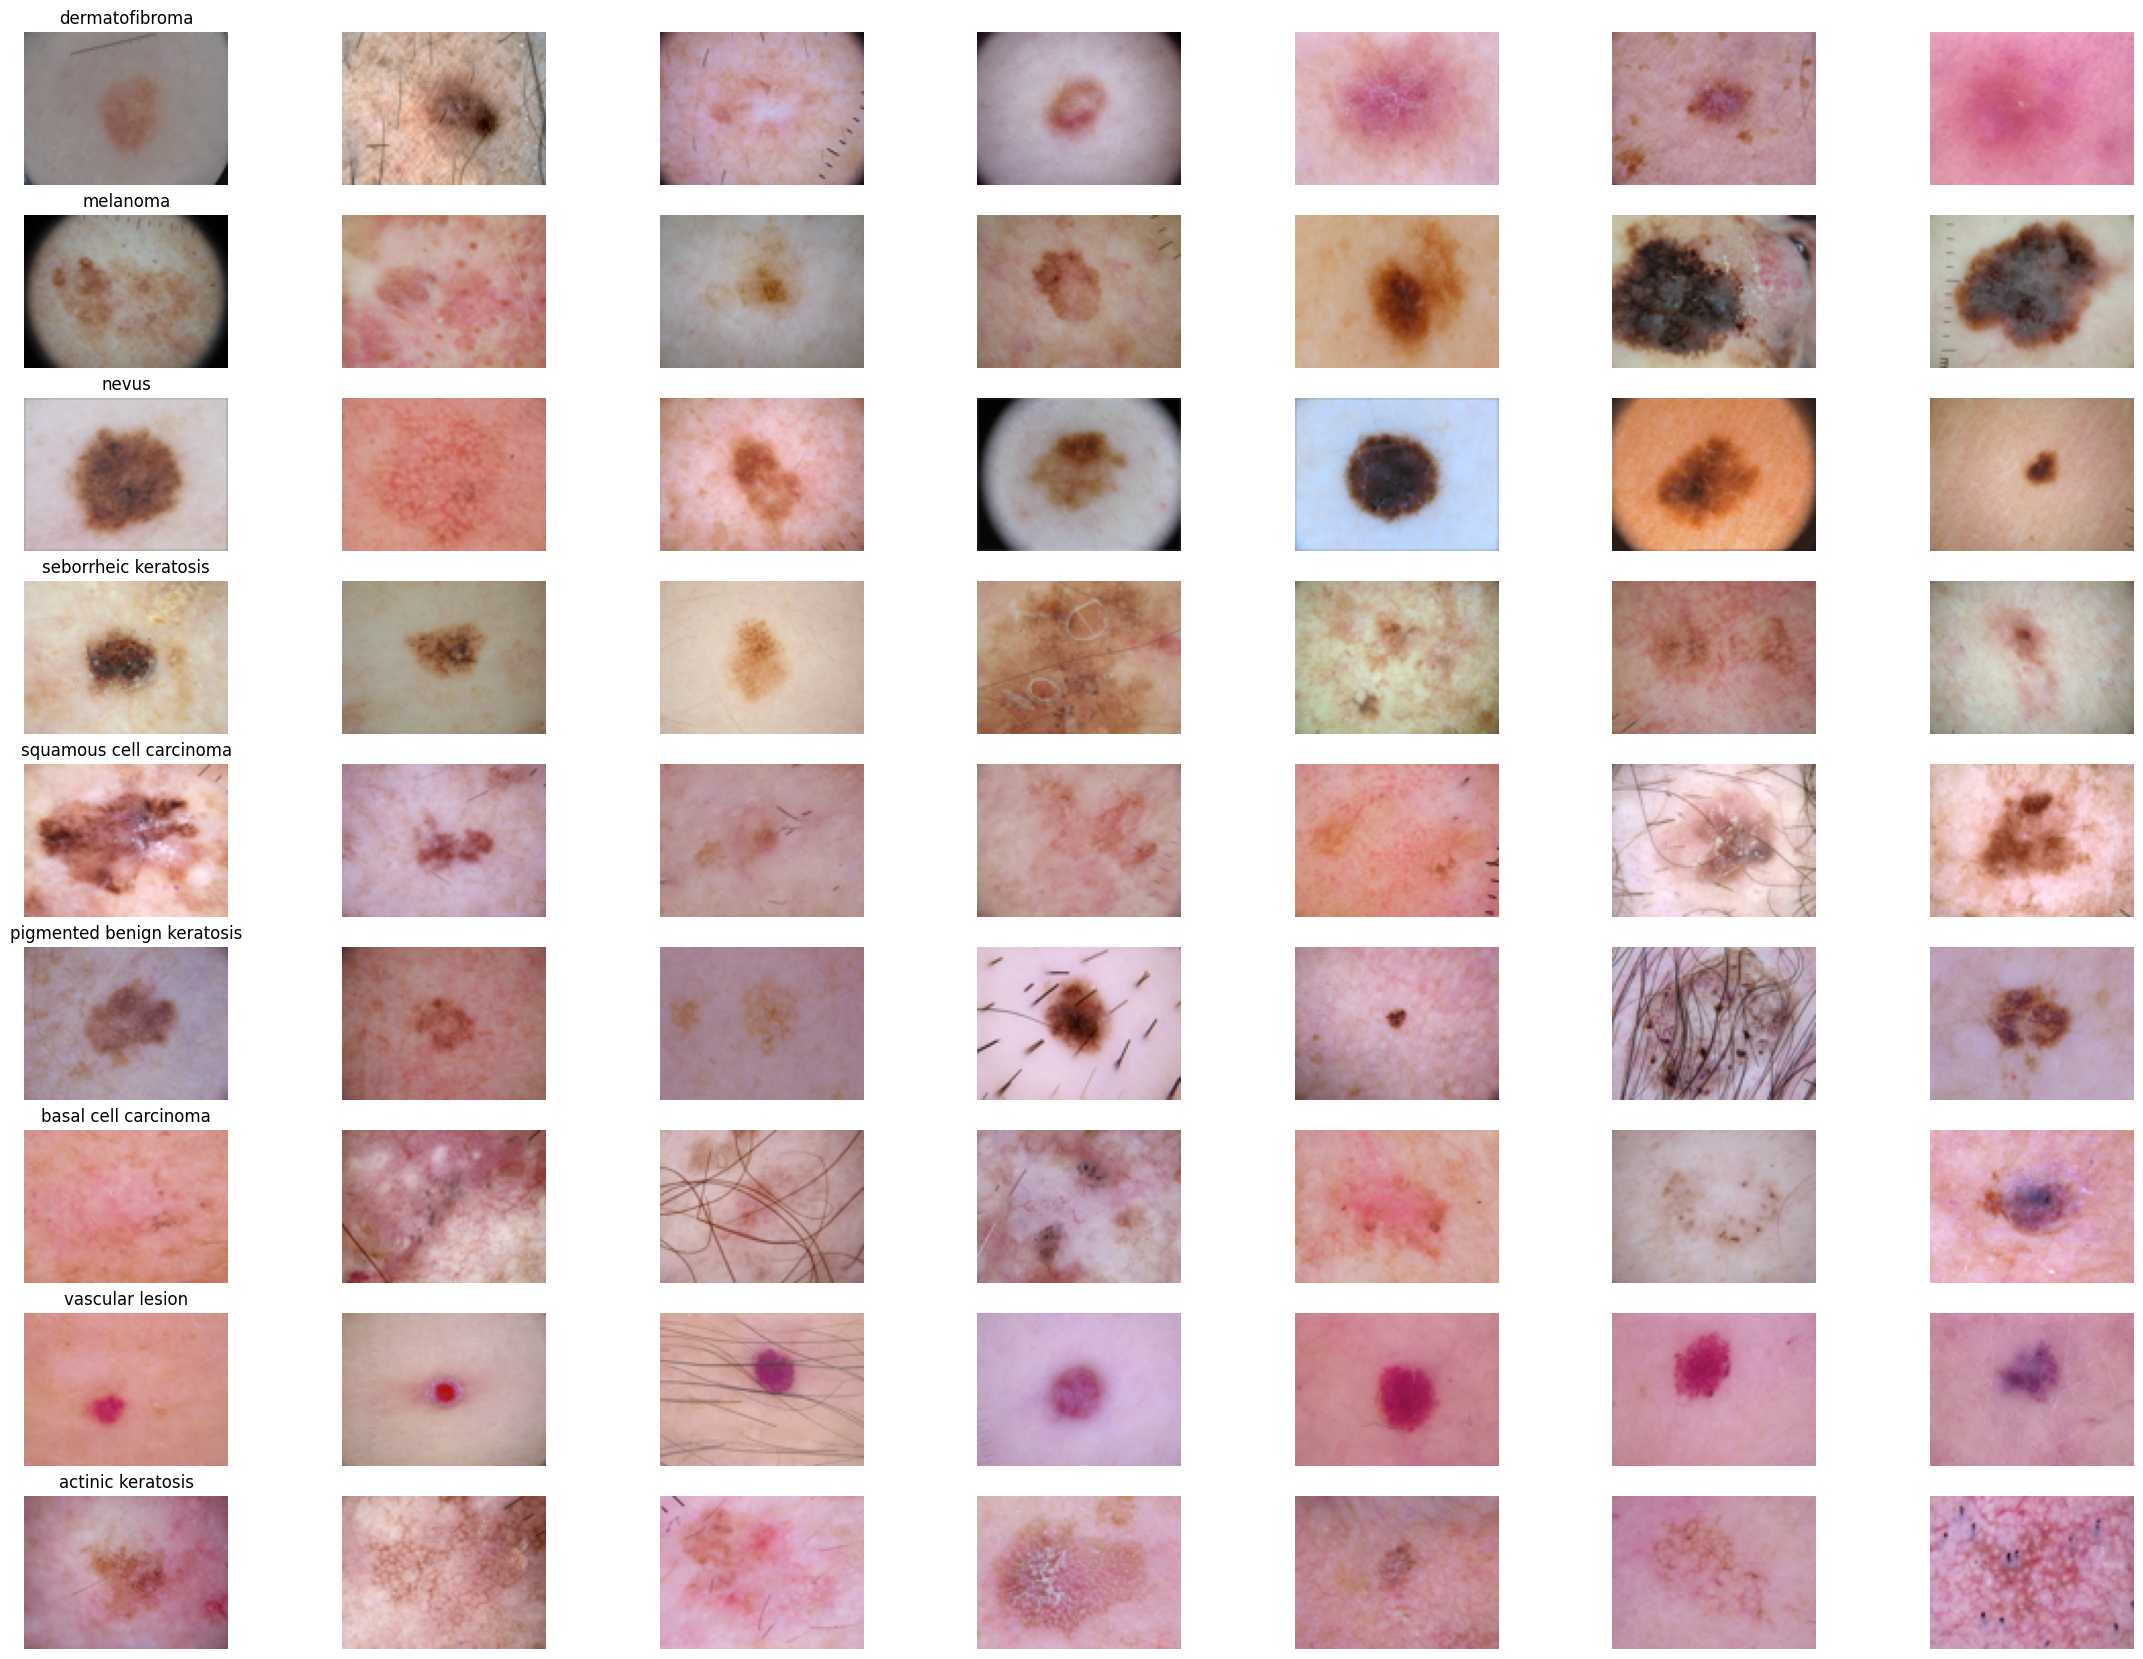

In [19]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [20]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    2357
Name: image, dtype: int64

In [21]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [22]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values

    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)

    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)

            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)

            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = pd.concat([augmented_df, pd.DataFrame({'image_path': [None], 'label': [class_label], 'image': [augmented_image_array]})], ignore_index=True)

    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

<ipython-input-22-0eab2db45a32>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(original_images_df, ignore_index=True)
<ipython-input-22-0eab2db45a32>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(original_images_df, ignore_index=True)
<ipython-input-22-0eab2db45a32>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(original_images_df, ignore_index=True)
<ipython-input-22-0eab2db45a32>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(original_images_df, ignore_index=True)
<ipython-input-22-0e

In [23]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               dermatofibroma                 2500      
1               melanoma                       2500      
2               nevus                          2500      
3               seborrheic keratosis           2500      
4               squamous cell carcinoma        2500      
5               pigmented benign keratosis     2500      
6               basal cell carcinoma           2500      
7               vascular lesion                2500      
8               actinic keratosis              2500      
------------------------------------------------------------
Total                                         22500     


In [24]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [25]:
features.head()

image
0  [[[232, 172, 204], [232, 170, 201], [231, 167,...
1  [[[204, 183, 162], [205, 184, 163], [206, 187,...
2  [[[209, 204, 203], [207, 200, 200], [206, 198,...
3  [[[86, 88, 101], [86, 88, 101], [86, 88, 101],...
4  [[[166, 142, 140], [167, 142, 139], [166, 138,...

In [26]:
target.head()

0    0
1    3
2    7
3    3
4    4
Name: label, dtype: object

In [27]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [28]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [29]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [30]:
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [31]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [32]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [33]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [34]:
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               dermatofibroma                 1552       421          527        2500      
1               melanoma                       1600       423          477        2500      
2               nevus                          1619       370          511        2500      
3               seborrheic keratosis           1597       384          519        2500      
4               squamous cell carcinoma        1577       414          509        2500      
5               pigmented benign keratosis     1621       410          469        2500      
6               basal cell carcinoma           1599       386          515        2500      
7               vascular lesion                1587       

In [35]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [36]:
input_shape = df['image'][0].shape

In [37]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

74836368/74836368 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 24225353 (92.41 MB)
Trainable params: 23996297 (91.54 MB)
Non-trainable params: 229056 (894.75 KB)
__________

In [38]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [39]:
epochs = 50
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/50
450/450 [==============================] - ETA: 0s - loss: 1.1787 - accuracy: 0.5823

450/450 [==============================] - 114s 114ms/step - loss: 1.1787 - accuracy: 0.5823 - val_loss: 0.6436 - val_accuracy: 0.7592 - lr: 0.0010
Epoch 2/50
450/450 [==============================] - ETA: 0s - loss: 0.5626 - accuracy: 0.7895

450/450 [==============================] - 47s 105ms/step - loss: 0.5626 - accuracy: 0.7895 - val_loss: 0.4357 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 3/50
450/450 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8794

450/450 [==============================] - 47s 104ms/step - loss: 0.3256 - accuracy: 0.8794 - val_loss: 0.3258 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 4/50
450/450 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9076

450/450 [==============================] - 47s 105ms/step - loss: 0.2444 - accuracy: 0.9076 - val_loss: 0.3487 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 5/50
450/450 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9217

450/450 [==============================] - 47s 105ms/step - loss: 0.2066 - accuracy: 0.9217 - val_loss: 0.2959 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 6/50
450/450 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9394

450/450 [==============================] - 47s 104ms/step - loss: 0.1591 - accuracy: 0.9394 - val_loss: 0.3526 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 7/50
450/450 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9460

450/450 [==============================] - 47s 105ms/step - loss: 0.1400 - accuracy: 0.9460 - val_loss: 0.3691 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 8/50
450/450 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9593

450/450 [==============================] - 47s 105ms/step - loss: 0.1066 - accuracy: 0.9593 - val_loss: 0.3100 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 9/50
450/450 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9676

450/450 [==============================] - 47s 105ms/step - loss: 0.0916 - accuracy: 0.9676 - val_loss: 0.3445 - val_accuracy: 0.8881 - lr: 0.0010
Epoch 10/50
450/450 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9677

450/450 [==============================] - 47s 105ms/step - loss: 0.0881 - accuracy: 0.9677 - val_loss: 0.3323 - val_accuracy: 0.9039 - lr: 0.0010
Epoch 11/50
450/450 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9735

450/450 [==============================] - 48s 106ms/step - loss: 0.0739 - accuracy: 0.9735 - val_loss: 0.3501 - val_accuracy: 0.9042 - lr: 0.0010
Epoch 12/50
450/450 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9772

450/450 [==============================] - 47s 104ms/step - loss: 0.0648 - accuracy: 0.9772 - val_loss: 0.3775 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 13/50
450/450 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9790

450/450 [==============================] - 47s 104ms/step - loss: 0.0559 - accuracy: 0.9790 - val_loss: 0.3601 - val_accuracy: 0.9081 - lr: 0.0010
Epoch 14/50
450/450 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9807

450/450 [==============================] - 47s 104ms/step - loss: 0.0546 - accuracy: 0.9807 - val_loss: 0.4551 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 15/50
450/450 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9787

450/450 [==============================] - 47s 104ms/step - loss: 0.0602 - accuracy: 0.9787 - val_loss: 0.4005 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 16/50
450/450 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9774

450/450 [==============================] - 47s 104ms/step - loss: 0.0630 - accuracy: 0.9774 - val_loss: 0.3744 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 17/50
450/450 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9822

450/450 [==============================] - 47s 104ms/step - loss: 0.0483 - accuracy: 0.9822 - val_loss: 0.3923 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 18/50
450/450 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9841

450/450 [==============================] - 47s 104ms/step - loss: 0.0433 - accuracy: 0.9841 - val_loss: 0.4511 - val_accuracy: 0.9042 - lr: 0.0010
Epoch 19/50
450/450 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9847

450/450 [==============================] - 46s 103ms/step - loss: 0.0403 - accuracy: 0.9847 - val_loss: 0.4048 - val_accuracy: 0.9058 - lr: 0.0010
Epoch 20/50
450/450 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9872

450/450 [==============================] - 47s 104ms/step - loss: 0.0347 - accuracy: 0.9872 - val_loss: 0.4325 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 21/50
450/450 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9850

450/450 [==============================] - 47s 105ms/step - loss: 0.0394 - accuracy: 0.9850 - val_loss: 0.4132 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 22/50
450/450 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9846

450/450 [==============================] - 47s 104ms/step - loss: 0.0411 - accuracy: 0.9846 - val_loss: 0.4129 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 23/50
450/450 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9890

450/450 [==============================] - 47s 104ms/step - loss: 0.0276 - accuracy: 0.9890 - val_loss: 0.4426 - val_accuracy: 0.9097 - lr: 0.0010
Epoch 24/50
450/450 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9907

450/450 [==============================] - 47s 105ms/step - loss: 0.0247 - accuracy: 0.9907 - val_loss: 0.4257 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 25/50
450/450 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9892

450/450 [==============================] - 47s 104ms/step - loss: 0.0291 - accuracy: 0.9892 - val_loss: 0.4522 - val_accuracy: 0.9064 - lr: 0.0010
Epoch 26/50
450/450 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9912

450/450 [==============================] - 47s 105ms/step - loss: 0.0226 - accuracy: 0.9912 - val_loss: 0.4531 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 27/50
450/450 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9912

450/450 [==============================] - 47s 104ms/step - loss: 0.0204 - accuracy: 0.9912 - val_loss: 0.4363 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 28/50
450/450 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9919

450/450 [==============================] - 47s 104ms/step - loss: 0.0194 - accuracy: 0.9919 - val_loss: 0.4171 - val_accuracy: 0.9169 - lr: 0.0010
Epoch 29/50
450/450 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9917

450/450 [==============================] - 47s 104ms/step - loss: 0.0193 - accuracy: 0.9917 - val_loss: 0.4499 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 30/50
450/450 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9904

450/450 [==============================] - 47s 104ms/step - loss: 0.0228 - accuracy: 0.9904 - val_loss: 0.4458 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 31/50
450/450 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9927

450/450 [==============================] - 47s 105ms/step - loss: 0.0178 - accuracy: 0.9927 - val_loss: 0.4934 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 32/50
450/450 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9912

450/450 [==============================] - 47s 105ms/step - loss: 0.0167 - accuracy: 0.9912 - val_loss: 0.4672 - val_accuracy: 0.9169 - lr: 0.0010
Epoch 33/50
450/450 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9917

450/450 [==============================] - 47s 105ms/step - loss: 0.0208 - accuracy: 0.9917 - val_loss: 0.4820 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 34/50
450/450 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9918

450/450 [==============================] - 47s 104ms/step - loss: 0.0182 - accuracy: 0.9918 - val_loss: 0.4811 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 35/50
450/450 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9892

450/450 [==============================] - 47s 105ms/step - loss: 0.0265 - accuracy: 0.9892 - val_loss: 0.5514 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 36/50
450/450 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9903

450/450 [==============================] - 48s 106ms/step - loss: 0.0229 - accuracy: 0.9903 - val_loss: 0.5411 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 37/50
450/450 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9901

450/450 [==============================] - 47s 104ms/step - loss: 0.0251 - accuracy: 0.9901 - val_loss: 0.5216 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 38/50
450/450 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9921

450/450 [==============================] - 47s 105ms/step - loss: 0.0184 - accuracy: 0.9921 - val_loss: 0.5123 - val_accuracy: 0.9161 - lr: 0.0010
Epoch 39/50
450/450 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9919

450/450 [==============================] - 47s 105ms/step - loss: 0.0167 - accuracy: 0.9919 - val_loss: 0.5030 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 40/50
450/450 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9919

450/450 [==============================] - 47s 104ms/step - loss: 0.0171 - accuracy: 0.9919 - val_loss: 0.5772 - val_accuracy: 0.9083 - lr: 0.0010
Epoch 41/50
450/450 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9924

450/450 [==============================] - 47s 105ms/step - loss: 0.0175 - accuracy: 0.9924 - val_loss: 0.4936 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 42/50
450/450 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9931

450/450 [==============================] - 47s 105ms/step - loss: 0.0150 - accuracy: 0.9931 - val_loss: 0.5063 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 43/50
450/450 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9920

450/450 [==============================] - 48s 106ms/step - loss: 0.0169 - accuracy: 0.9920 - val_loss: 0.5558 - val_accuracy: 0.9139 - lr: 0.0010
Epoch 44/50
450/450 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9924

450/450 [==============================] - 47s 105ms/step - loss: 0.0154 - accuracy: 0.9924 - val_loss: 0.4769 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 45/50
450/450 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9926

450/450 [==============================] - 47s 104ms/step - loss: 0.0154 - accuracy: 0.9926 - val_loss: 0.4833 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 46/50
450/450 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9927

450/450 [==============================] - 46s 101ms/step - loss: 0.0147 - accuracy: 0.9927 - val_loss: 0.5691 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 47/50
450/450 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9911

450/450 [==============================] - 45s 101ms/step - loss: 0.0213 - accuracy: 0.9911 - val_loss: 0.5179 - val_accuracy: 0.9136 - lr: 0.0010
Epoch 48/50
450/450 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9915

450/450 [==============================] - 46s 102ms/step - loss: 0.0209 - accuracy: 0.9915 - val_loss: 0.5588 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 49/50
450/450 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9902

450/450 [==============================] - 46s 102ms/step - loss: 0.0217 - accuracy: 0.9902 - val_loss: 0.4936 - val_accuracy: 0.9106 - lr: 0.0010
Epoch 50/50
450/450 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9919

450/450 [==============================] - 46s 102ms/step - loss: 0.0170 - accuracy: 0.9919 - val_loss: 0.5301 - val_accuracy: 0.9211 - lr: 0.0010


In [40]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 8s 18ms/step - loss: 0.0076 - accuracy: 0.9955
Train: accuracy = 0.995486  ;  loss = 0.007611


In [41]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 6s 18ms/step - loss: 0.5670 - accuracy: 0.9140
Testing: accuracy = 0.914000  ;  loss = 0.566990


141/141 [==============================] - 5s 16ms/step


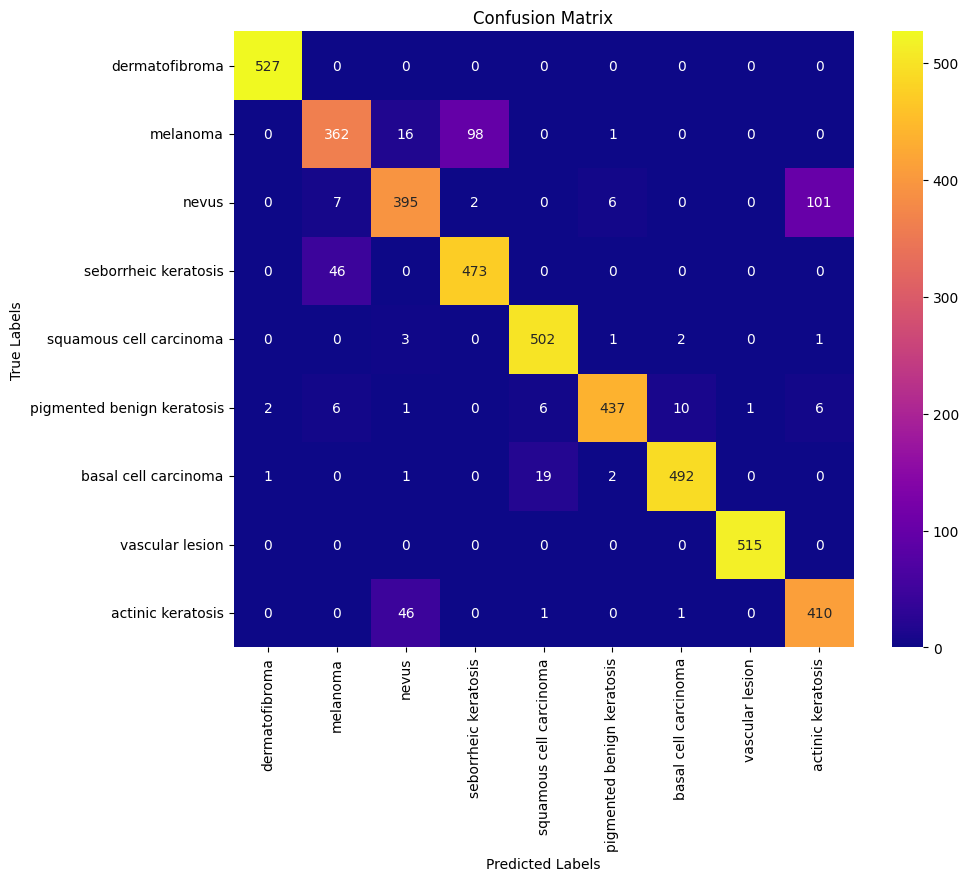

In [42]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.9140
Precision: 0.9141
Recall: 0.9124
F1-score: 0.9120
Kappa score: 0.9032


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

class_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

class_precision = precision_score(np.argmax(y_test, axis=1), y_pred, average=None)
class_recall = recall_score(np.argmax(y_test, axis=1), y_pred, average=None)
class_f1_score = f1_score(np.argmax(y_test, axis=1), y_pred, average=None)

class_kappa_score = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

for class_label, class_name in enumerate(label_map.values()):
    print(f"Class: {class_name}")
    print(f"Accuracy: {class_accuracy:.4f}")
    print(f"Precision: {class_precision[class_label]:.4f}")
    print(f"Recall: {class_recall[class_label]:.4f}")
    print(f"F1-score: {class_f1_score[class_label]:.4f}")
    print(f"Kappa score: {class_kappa_score:.4f}")
    print()


141/141 [==============================] - 2s 16ms/step
Class: dermatofibroma
Accuracy: 0.9140
Precision: 0.9943
Recall: 1.0000
F1-score: 0.9972
Kappa score: 0.9032

Class: melanoma
Accuracy: 0.9140
Precision: 0.8599
Recall: 0.7589
F1-score: 0.8062
Kappa score: 0.9032

Class: nevus
Accuracy: 0.9140
Precision: 0.8550
Recall: 0.7730
F1-score: 0.8119
Kappa score: 0.9032

Class: seborrheic keratosis
Accuracy: 0.9140
Precision: 0.8255
Recall: 0.9114
F1-score: 0.8663
Kappa score: 0.9032

Class: squamous cell carcinoma
Accuracy: 0.9140
Precision: 0.9508
Recall: 0.9862
F1-score: 0.9682
Kappa score: 0.9032

Class: pigmented benign keratosis
Accuracy: 0.9140
Precision: 0.9776
Recall: 0.9318
F1-score: 0.9541
Kappa score: 0.9032

Class: basal cell carcinoma
Accuracy: 0.9140
Precision: 0.9743
Recall: 0.9553
F1-score: 0.9647
Kappa score: 0.9032

Class: vascular lesion
Accuracy: 0.9140
Precision: 0.9981
Recall: 1.0000
F1-score: 0.9990
Kappa score: 0.9032

Class: actinic keratosis
Accuracy: 0.9140
Pre

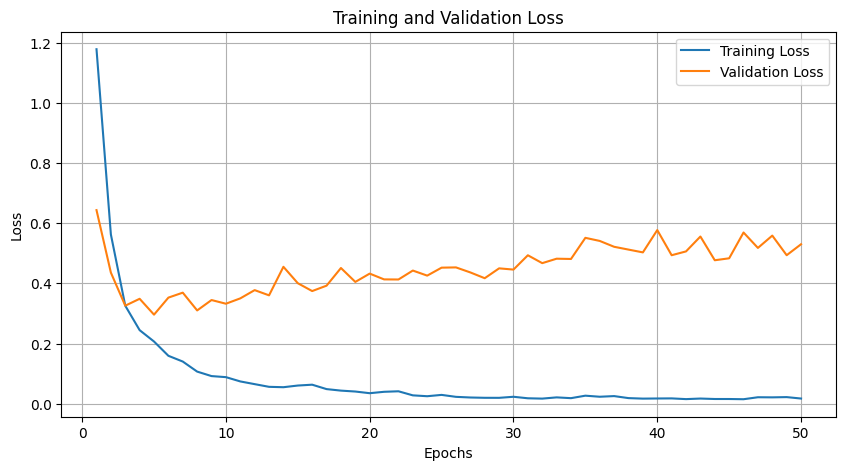

In [45]:
import matplotlib.pyplot as plt

# Extract loss history from the existing history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


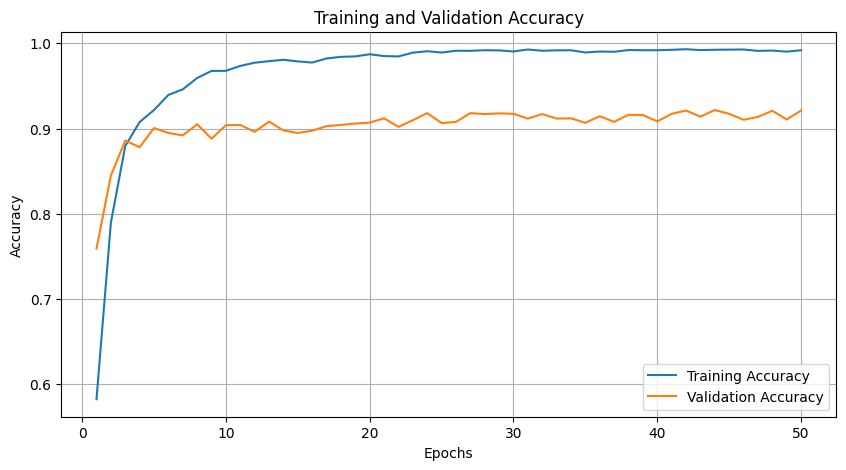

In [46]:
import matplotlib.pyplot as plt

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 5))

plt.plot(range(1, epochs + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()


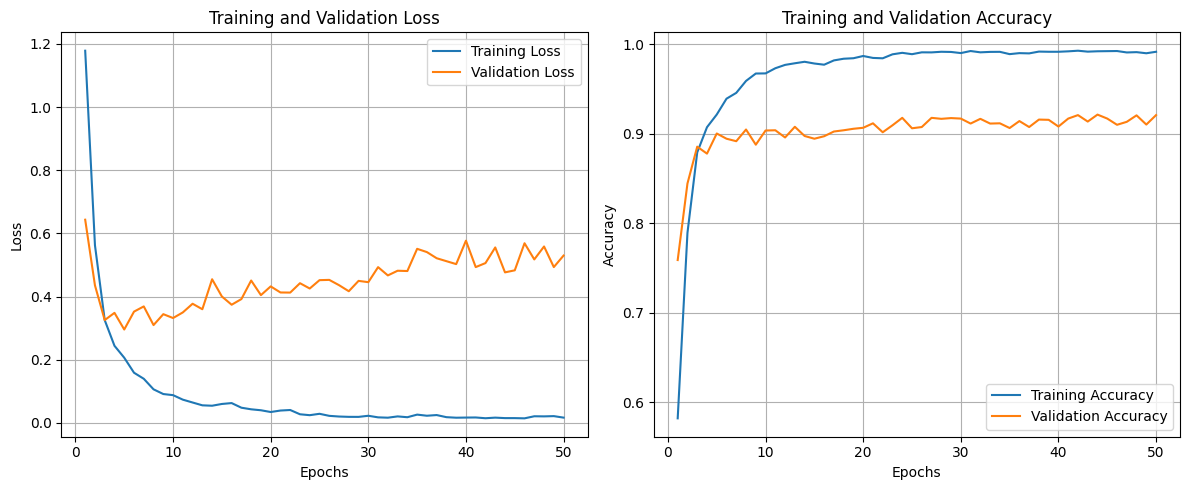

In [47]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, epochs + 1), training_loss, label='Training Loss')
ax1.plot(range(1, epochs + 1), validation_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, epochs + 1), training_accuracy, label='Training Accuracy')
ax2.plot(range(1, epochs + 1), validation_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [48]:
model.save("skinCancerClassification_UsningCNN.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 11.2 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.1-py3-none-any.whl size=55

In [50]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image

model = keras.models.load_model("skinCancerClassification_UsningCNN.h5")

class_labels = {
    0: 'dermatofibroma',
    1: 'melanoma',
    2: 'nevus',
    3: 'seborrheic keratosis',
    4: 'squamous cell carcinoma',
    5: 'pigmented benign keratosis',
    6: 'basal cell carcinoma',
    7: 'vascular lesion',
    8: 'actinic keratosis'
}

def classify_skin_cancer(image):
    image = np.array(image)
    image = tf.image.resize(image, (75, 100))
    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    class_index = np.argmax(predictions)
    class_name = class_labels[class_index]

    confidence = np.max(predictions)

    return f"Predicted Class: {class_name}\nConfidence: {confidence:.2f}"

iface = gr.Interface(
    fn=classify_skin_cancer,
    inputs="image",
    outputs="text",
    live=True,
    title="Skin Cancer Classification",
    description="Upload an image of a skin lesion to classify its type."
)

iface.launch()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>